In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import date
from datetime import timedelta
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

## Read the daily files
### NOTE: The Province/Region field is used inconsistently before 3/22.
###       If you read files before 3/22, only report at the country level.

In [2]:
base_path = 'csse_covid_19_data/csse_covid_19_daily_reports/'

#start = date.fromisoformat('2020-02-29')
start = date.fromisoformat('2020-03-22')  # prior to 3/22 the format is different and province/state has a mix of counties, and states, etc.
end = date.today()

df_all = pd.DataFrame(columns=['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
                              'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key'])

def rename_column_if_exists(df, old_col_name, new_col_name):
    if old_col_name in df.columns:
        df.rename(columns = {old_col_name: new_col_name}, inplace=True)
        
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                    [df[col] for col in cols])

def create_combined_key_if_missing(df):
    if not 'Combined_Key' in df.columns:
        df.insert(len(df.columns), 'Combined_Key', np.NaN)
    df_missing = df['Combined_Key'].isna()
    df.loc[df_missing,'Combined_Key'] = df.loc[df_missing,:].Province_State.astype(str).str.cat(df.loc[df_missing,:].Country_Region.astype(str), sep=', ', na_rep='')
    
d = end - start
for dayindex in range(0,d.days+1):
    day = start + timedelta(days=dayindex)
    filename = '{:%m-%d-%Y}'.format(day)
    #print(base_path + filename + '.csv')
    try:
        df_input = pd.read_csv(base_path + filename + '.csv')
    except FileNotFoundError as e:
        print('FileNotFoundError - {}'.format(base_path + filename + '.csv'))
        continue
    rename_column_if_exists(df_input, 'Province/State', 'Province_State')
    rename_column_if_exists(df_input, 'Country/Region', 'Country_Region')
    rename_column_if_exists(df_input, 'Last Update', 'Last_Update')
    rename_column_if_exists(df_input, 'Latitude', 'Lat')
    rename_column_if_exists(df_input, 'Longitude', 'Long_')
    create_combined_key_if_missing(df_input)
    df_all = df_all.append(df_input)
    
df_all['Last_Update'] = pd.to_datetime(df_all.Last_Update) 
df_all['Last_Update'] = pd.to_datetime(df_all['Last_Update'].dt.date)  # the ".dt.date" collapses more granular datetime to just the day (so time-of-day differences aren't on different rows)
    
df_all.loc[df_all['Country_Region']=='Guatemala',:]


#df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_daily_reports/03-30-2020.csv')
#df_raw.head(30)

FileNotFoundError - csse_covid_19_data/csse_covid_19_daily_reports/06-06-2020.csv


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
3345,NaN,NaN,NaN,Guatemala,2020-03-22,15.7835,-90.2308,19,1,0,18,Guatemala,NaN,NaN
3312,NaN,NaN,NaN,Guatemala,2020-03-23,15.7835,-90.2308,20,1,0,19,Guatemala,NaN,NaN
3313,NaN,NaN,NaN,Guatemala,2020-03-24,15.7835,-90.2308,21,1,0,20,Guatemala,NaN,NaN
3314,NaN,NaN,NaN,Guatemala,2020-03-25,15.7835,-90.2308,24,1,4,19,Guatemala,NaN,NaN
3313,NaN,NaN,NaN,Guatemala,2020-03-26,15.7835,-90.2308,25,1,4,20,Guatemala,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3527,NaN,NaN,NaN,Guatemala,2020-06-02,15.7835,-90.2308,5336,116,795,4425,Guatemala,29.784154,2.173913
3531,NaN,NaN,NaN,Guatemala,2020-06-03,15.7835,-90.2308,5586,123,824,4639,Guatemala,31.179588,2.201933
3534,NaN,NaN,NaN,Guatemala,2020-06-04,15.7835,-90.2308,5760,143,929,4688,Guatemala,32.150811,2.482639
3535,NaN,NaN,NaN,Guatemala,2020-06-05,15.7835,-90.2308,6154,158,979,5017,Guatemala,34.350015,2.567436


In [3]:
# Clean it up -- drop unneeded columns and set date as the index
df_clean = df_all.drop(labels=['FIPS', 'Lat', 'Long_'], axis=1)
df_clean = df_clean.melt(id_vars=['Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'Last_Update'],
            var_name='Metric',
            value_name='Value')
df_clean = df_clean.set_index('Last_Update')
df_clean.loc[df_clean['Country_Region']=='Guatemala'].tail()

,Admin2,Province_State,Country_Region,Combined_Key,Metric,Value
Last_Update,,,,,,
2020-06-02,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,2.17391
2020-06-03,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,2.20193
2020-06-04,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,2.48264
2020-06-05,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,2.56744
2020-06-06,NaN,NaN,Guatemala,Guatemala,Case-Fatality_Ratio,3.33076


In [4]:
# Examples of dealing with the data in this format

# Just the death information for Santa Clara County
df_clean.loc[(df_clean.Admin2 == 'Santa Clara') & (df_clean.Metric == 'Deaths')]

# Just Confirmed Cases for Canadian Provinces
df_clean.loc[(df_clean.Metric == 'Confirmed') & (df_clean.Country_Region == 'Canada'), ['Province_State', 'Value']]

# Get the above (confirmed for Canadian Provinces) ready to graph (wide format with column labels being location)
(df_clean.loc[(df_clean.Metric == 'Confirmed') & (df_clean.Country_Region == 'Canada'), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum) #pivot() doesn't work because of duplicate indices
)

Province_State,Alberta,British Columbia,Diamond Princess,Grand Princess,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Ontario,Prince Edward Island,Quebec,Recovered,Saskatchewan,Yukon
Last_Update,,,,,,,,,,,,,,,
2020-03-22,259.0,424.0,0.0,13.0,20.0,17.0,9.0,1.0,28.0,425.0,3.0,219.0,NaN,52.0,NaN
2020-03-23,301.0,472.0,0.0,13.0,20.0,17.0,24.0,NaN,41.0,503.0,3.0,628.0,NaN,66.0,NaN
2020-03-24,359.0,617.0,0.0,13.0,21.0,18.0,35.0,NaN,51.0,588.0,3.0,1013.0,0.0,72.0,NaN
2020-03-25,358.0,617.0,0.0,13.0,35.0,18.0,35.0,NaN,68.0,688.0,5.0,1342.0,0.0,72.0,NaN
2020-03-26,486.0,725.0,0.0,13.0,36.0,33.0,82.0,1.0,73.0,858.0,5.0,1632.0,0.0,95.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-02,7044.0,2597.0,1.0,13.0,295.0,132.0,261.0,5.0,1057.0,29845.0,27.0,51354.0,NaN,646.0,11.0
2020-06-03,7057.0,2601.0,NaN,13.0,297.0,133.0,261.0,5.0,1057.0,30259.0,27.0,51593.0,NaN,646.0,11.0
2020-06-04,7076.0,2623.0,0.0,13.0,298.0,135.0,261.0,5.0,1058.0,30603.0,27.0,51884.0,NaN,647.0,11.0


### Label_lines routine - now with tuple_selector option

In [5]:
def label_lines(df, ax, tuple_selector=None, print_value=False):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        if not (tuple_selector is None):
            if print_value:
                label = '{} ({:,})'.format(label[tuple_selector], int(prev_data))
            else:
                label = label[tuple_selector]
        else:
            if print_value:
                label = '{} ({:,})'.format(label, int(prev_data))
        ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')

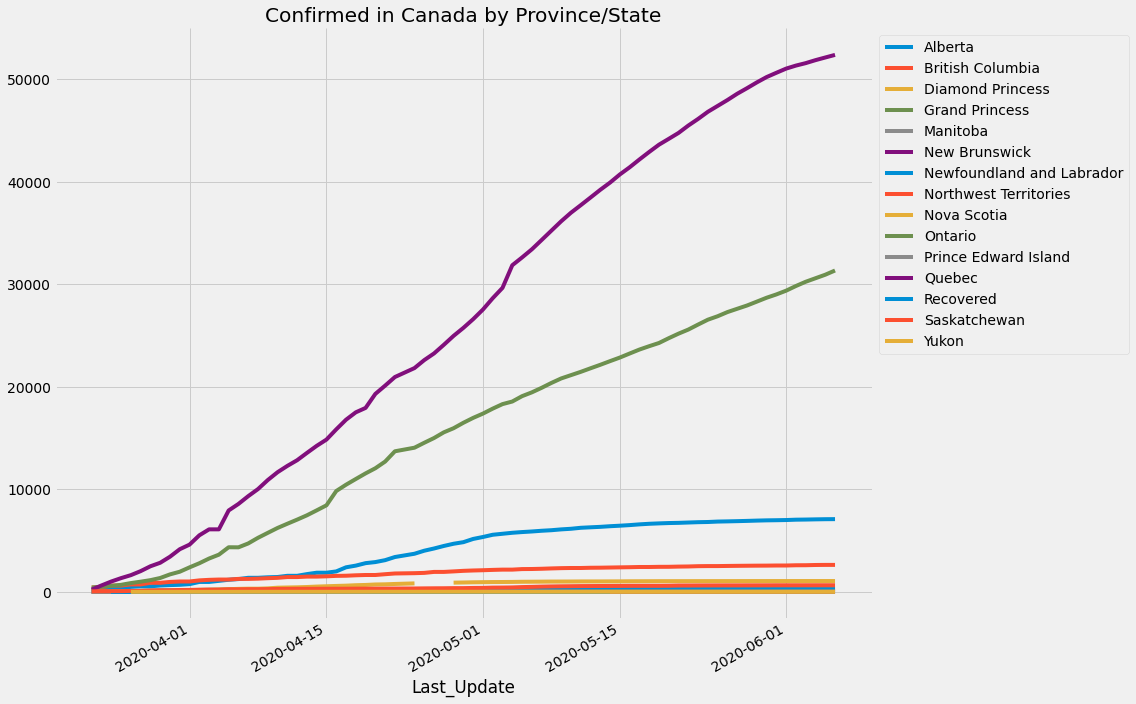

In [6]:
metric = 'Confirmed'
location = 'Canada'
(df_clean.loc[(df_clean.Metric == metric) & (df_clean.Country_Region == location), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum)
     .loc['2020-03':,:]
).plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.title('{} in {} by Province/State'.format(metric, location))
plt.tight_layout()
sns.despine()
plt.show()

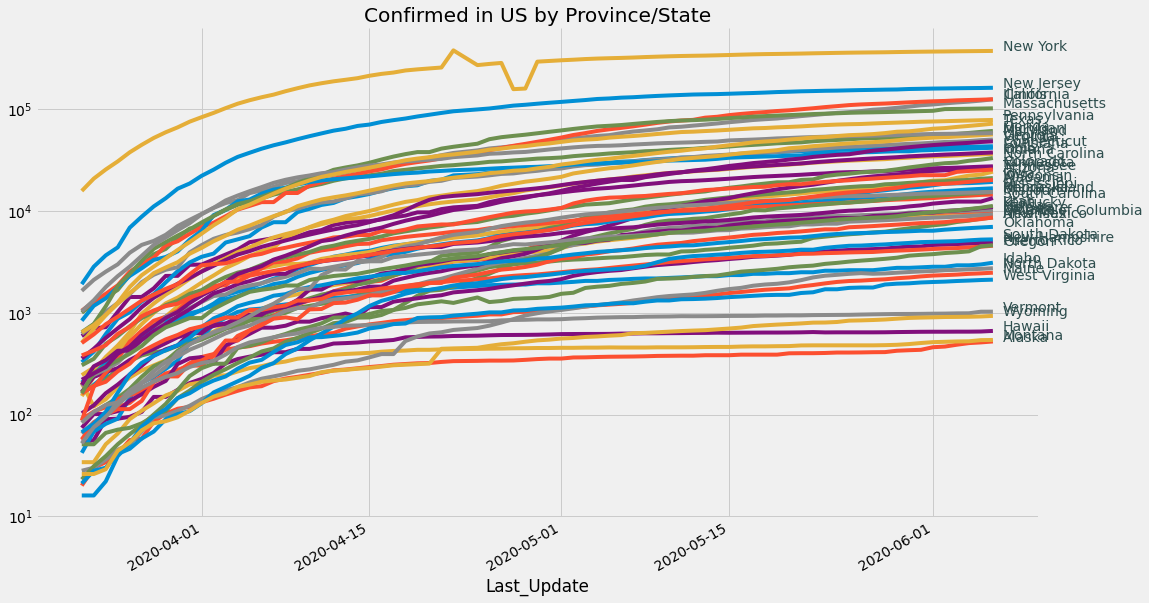

In [7]:
metric = 'Confirmed'
location = 'US'
graphdf = (df_clean.loc[(df_clean.Metric == metric) & (df_clean.Country_Region == location), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum)
     .loc['2020-03-22':,:]
     .drop(date.fromisoformat('2020-04-23'), axis=0) # this row has all NaNs which mess things up
     .dropna(axis=1, how='any')
     .drop(['Northern Mariana Islands', 'Virgin Islands', 'Diamond Princess', 'Grand Princess', 'Guam'], axis=1)
)
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, tuple_selector=None, print_value=False)
plt.title('{} in {} by Province/State'.format(metric, location))
#plt.tight_layout()
sns.despine()
plt.show()


## Alternative one -- just use Combined_Key

In [8]:
#piv1 = df_clean.pivot_table(index=df_clean.index, columns=['Metric','Combined_Key'], values='Value', aggfunc=np.sum)
#piv1.tail() # Note the MultiIndex for the columns (Metric, Combined_Key)

In [9]:
# look at just the deaths (Metric == 'Deaths') aka the top level of the MultiIndex is 'Deaths'

#idx = pd.IndexSlice
#piv1.loc[:,idx['Deaths']]

In [10]:
# Look at just deaths in California
# (must use columns.map() because you can't use .str.endswith on a MultiIndex)

#piv1.loc[:,idx['Deaths', piv1.columns.map(lambda x: x[1].endswith('California, US'))]]

## Alternative Two (PREFERRED) - Use Country, State, Admin2 fields

First, an example of dealing with a column you want to use in a pivot_table that has nulls.

In [11]:
test = pd.DataFrame(
                    [
                        ['US','California',1],
                        ['US','New York',3],
                        ['Italy',np.NaN,10]
                    ],
                    columns = ['country', 'state', 'value'],
                   )
print(test)
print('\nIf you dont fix the null values and use pivot_table specifying a column with null values, youll lose info (as we lose Italy here)')
print(test.pivot_table( index=test.index, 
            columns=['country','state'], 
            values=['value'], 
            aggfunc=np.sum, 
            dropna=True ) )
print('\nNow do a .fillna(value={"column_name":"new_value"}) first and it is OK')
(test
     .fillna(value={'state':'none'})
     .pivot_table( index=test.index, 
            columns=['country','state'], 
            values=['value'], 
            aggfunc=np.sum, 
            dropna=True ) 
)

  country       state  value
0      US  California      1
1      US    New York      3
2   Italy         NaN     10

If you dont fix the null values and use pivot_table specifying a column with null values, youll lose info (as we lose Italy here)
             value         
country         US         
state   California New York
0              1.0      NaN
1              NaN      3.0

Now do a .fillna(value={"column_name":"new_value"}) first and it is OK


value                    
country Italy         US         
state    none California New York
0         NaN        1.0      NaN
1         NaN        NaN      3.0
2        10.0        NaN      NaN

In [12]:
df = (df_clean
          .fillna(value={'Province_State':'none', 'Admin2':'none', 'Country_Region':'none'}) # if you don't do this, countries without state or admin2 will be filtered out.
          .pivot_table(index=df_clean.index, 
                          columns=['Metric','Country_Region','Province_State','Admin2'], 
                          values=['Value'], 
                          aggfunc=np.sum
                      )
     )
df = df.loc['20200322':,:]
df = df.drop(date.fromisoformat('2020-04-23'), axis=0) # this row has all NaNs which mess things up
df

Value                                                     \
Metric              Active                                                      
Country_Region Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda   
Province_State        none    none    none    none   none                none   
Admin2                none    none    none    none   none                none   
Last_Update                                                                     
2020-03-22            38.0    85.0   119.0   111.0    2.0                 1.0   
2020-03-23            38.0    98.0   148.0   131.0    3.0                 3.0   
2020-03-24            72.0   108.0   221.0   162.0    3.0                 3.0   
2020-03-25            80.0   124.0   216.0   186.0    3.0                 3.0   
2020-03-26            88.0   151.0   313.0   220.0    4.0                 7.0   
...                    ...     ...     ...     ...    ...                 ...   
2020-06-02         14057.0   233.0  2958.0    16.0   64.0                 4.0   
2020-06-03         14789.0   240.0  2892.0    60.0   64.0                 3.0   
2020-06-04         15451.0   253.0  2842.0    65.0   64.0                 3.0   
2020-06-05         16169.0   266.0  2853.0    63.0   64.0                 3.0   
2020-06-06         16898.0   269.0  2792.0    60.0   61.0                 3.0   

                                                               \
Metric                                                          
Country_Region Argentina Armenia                    Australia   
Province_State      none    none Australian Capital Territory   
Admin2              none    none                         none   
Last_Update                                                     
2020-03-22         235.0   192.0                         19.0   
2020-03-23         235.0   233.0                         32.0   
2020-03-24         329.0   235.0                         39.0   
2020-03-25         327.0   249.0                         39.0   
2020-03-26         430.0   271.0                         52.0   
...                  ...     ...                          ...   
2020-06-02       11338.0  5951.0                          0.0   
2020-06-03       12041.0  6424.0                          0.0   
2020-06-04       12789.0  6900.0                          0.0   
2020-06-05       13596.0  7577.0                          0.0   
2020-06-06       14317.0  8121.0                          0.0   

                                     ...                                    \
Metric                               ...      Recovered                      
Country_Region                       ... United Kingdom Uruguay Uzbekistan   
Province_State External territories  ...           none    none       none   
Admin2                         none  ...           none    none       none   
Last_Update                          ...                                     
2020-03-22                      0.0  ...           93.0     0.0        0.0   
2020-03-23                      NaN  ...          135.0     0.0        0.0   
2020-03-24                      NaN  ...          135.0     0.0        0.0   
2020-03-25                      NaN  ...          135.0     0.0        0.0   
2020-03-26                      NaN  ...          135.0     0.0        0.0   
...                             ...  ...            ...     ...        ...   
2020-06-02                      NaN  ...            0.0   689.0     2859.0   
2020-06-03                      NaN  ...            0.0   691.0     2908.0   
2020-06-04                      NaN  ...            0.0   698.0     3014.0   
2020-06-05                      NaN  ...            0.0   709.0     3087.0   
2020-06-06                      NaN  ...            0.0   721.0     3247.0   

                                                                          \
Metric                                                                     
Country_Region Venezuela Vietnam West Bank and Gaza Wester

#### Trick:  Deleting columns with all zeros

In [13]:
test = pd.DataFrame([[1,0,0,0], [0,0,0,0],[0,0,1,0]], columns=['a','b','c','d'])
print(test)

print('\n"test!=0"  gives a true/false where there are non-zeros')
print(test!=0)

print('\nThe "any" function with axis=0 reduces along row to give true for any column with a true in it')
print((test!=0).any(axis=0))

print('\nNow just select the rows with a true in order to drop the columns with all zeros\ntest.loc[:,(test!=0).any(axis=0)]')
print(test.loc[:,(test!=0).any(axis=0)])

print('\nTo drop *rows* of all zero, just change axis=1 and put it in the rows position of loc instead \ntest.loc[(test!=0).any(axis=1),:]')
print(test.loc[(test!=0).any(axis=1),:])

   a  b  c  d
0  1  0  0  0
1  0  0  0  0
2  0  0  1  0

"test!=0"  gives a true/false where there are non-zeros
       a      b      c      d
0   True  False  False  False
1  False  False  False  False
2  False  False   True  False

The "any" function with axis=0 reduces along row to give true for any column with a true in it
a     True
b    False
c     True
d    False
dtype: bool

Now just select the rows with a true in order to drop the columns with all zeros
test.loc[:,(test!=0).any(axis=0)]
   a  c
0  1  0
1  0  0
2  0  1

To drop *rows* of all zero, just change axis=1 and put it in the rows position of loc instead 
test.loc[(test!=0).any(axis=1),:]
   a  b  c  d
0  1  0  0  0
2  0  0  1  0


### Using pd.IndexSlice and slice()

In [14]:
idx = pd.IndexSlice
Any = slice(None)  # could also just use ":", but this is a bit clearer

df.loc[:,idx[Any,Any,Any,Any,'Santa Clara']]

Value                                              \
Metric              Active Case-Fatality_Ratio   Confirmed      Deaths   
Country_Region          US                  US          US          US   
Province_State  California          California  California  California   
Admin2         Santa Clara         Santa Clara Santa Clara Santa Clara   
Last_Update                                                              
2020-03-22             0.0            0.000000       263.0         8.0   
2020-03-23             0.0            0.000000       302.0        10.0   
2020-03-24             0.0            0.000000       375.0        16.0   
2020-03-25             0.0            0.000000       459.0        17.0   
2020-03-26             0.0            0.000000       542.0        19.0   
...                    ...                 ...         ...         ...   
2020-06-02          2635.0            5.079251      2776.0       141.0   
2020-06-03          2676.0            5.072721      2819.0       143.0   
2020-06-04          2688.0            5.084746      2832.0       144.0   
2020-06-05          2706.0            5.052632      2850.0       144.0   
2020-06-06          2748.0            4.979253      2892.0       144.0   

                                           
Metric         Incidence_Rate   Recovered  
Country_Region             US          US  
Province_State     California  California  
Admin2            Santa Clara Santa Clara  
Last_Update                                
2020-03-22           0.000000         0.0  
2020-03-23           0.000000         0.0  
2020-03-24           0.000000         0.0  
2020-03-25           0.000000         0.0  
2020-03-26           0.000000         0.0  
...                       ...         ...  
2020-06-02         143.994456         0.0  
2020-06-03         146.224918         0.0  
2020-06-04         146.899243         0.0  
2020-06-05         147.832925         0.0  
2020-06-06         150.011515         0.0  

[76 rows x 6 columns]

In [15]:
# eliminate all the columns that are all zero and all the rows that are all zero
# note how using lambda allows us to do this without using temp variables for the 'deaths'/'california' subset
test = (df.loc[:,idx[:,'Deaths',:,'California']]
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )


# eliminate all the columns that are all zero and all the rows that are all zero
df = (df
           .fillna(value=0)                        # replace NaN with zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )
df

Value                                                     \
Metric              Active                                                      
Country_Region Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda   
Province_State        none    none    none    none   none                none   
Admin2                none    none    none    none   none                none   
Last_Update                                                                     
2020-03-22            38.0    85.0   119.0   111.0    2.0                 1.0   
2020-03-23            38.0    98.0   148.0   131.0    3.0                 3.0   
2020-03-24            72.0   108.0   221.0   162.0    3.0                 3.0   
2020-03-25            80.0   124.0   216.0   186.0    3.0                 3.0   
2020-03-26            88.0   151.0   313.0   220.0    4.0                 7.0   
...                    ...     ...     ...     ...    ...                 ...   
2020-06-02         14057.0   233.0  2958.0    16.0   64.0                 4.0   
2020-06-03         14789.0   240.0  2892.0    60.0   64.0                 3.0   
2020-06-04         15451.0   253.0  2842.0    65.0   64.0                 3.0   
2020-06-05         16169.0   266.0  2853.0    63.0   64.0                 3.0   
2020-06-06         16898.0   269.0  2792.0    60.0   61.0                 3.0   

                                                                               \
Metric                                                                          
Country_Region Argentina Armenia                    Australia                   
Province_State      none    none Australian Capital Territory New South Wales   
Admin2              none    none                         none            none   
Last_Update                                                                     
2020-03-22         235.0   192.0                         19.0           659.0   
2020-03-23         235.0   233.0                         32.0           659.0   
2020-03-24         329.0   235.0                         39.0           807.0   
2020-03-25         327.0   249.0                         39.0          1018.0   
2020-03-26         430.0   271.0                         52.0          1208.0   
...                  ...     ...                          ...             ...   
2020-06-02       11338.0  5951.0                          0.0           369.0   
2020-06-03       12041.0  6424.0                          0.0           365.0   
2020-06-04       12789.0  6900.0                          0.0           358.0   
2020-06-05       13596.0  7577.0                          0.0           348.0   
2020-06-06       14317.0  8121.0                          0.0           343.0   

                ...                                                      \
Metric          ...      Recovered                                        
Country_Region  ... United Kingdom Uruguay Uzbekistan Venezuela Vietnam   
Province_State  ...           none    none       none      none    none   
Admin2          ...           none    none       none      none    none   
Last_Update     ...                                                       
2020-03-22      ...           93.0     0.0        0.0      15.0    17.0   
2020-03-23      ...          135.0     0.0        0.0      15.0    17.0   
2020-03-24      ...          135.0     0.0        0.0      15.0    17.0   
2020-03-25      ...          135.0     0.0        0.0      15.0    17.0   
2020-03-26      ...          135.0     0.0        0.0      15.0    20.0   
...             ...            ...     ...        ...       ...     ...   
2020-06-02      ...            0.0   689.0     2859.0     302.0   293.0   
2020-06-03      ...            0.0   691.0     2908.0     334.0   298.0   
2020-06-04      ...            0.0   698.0     3014.0     334.0   302.0   
2020-06-05      ...            0.0   709.0     3087.0     334.0   302.0   
2020-06-06      ...            0.0   721.0     3247.0     334.0  

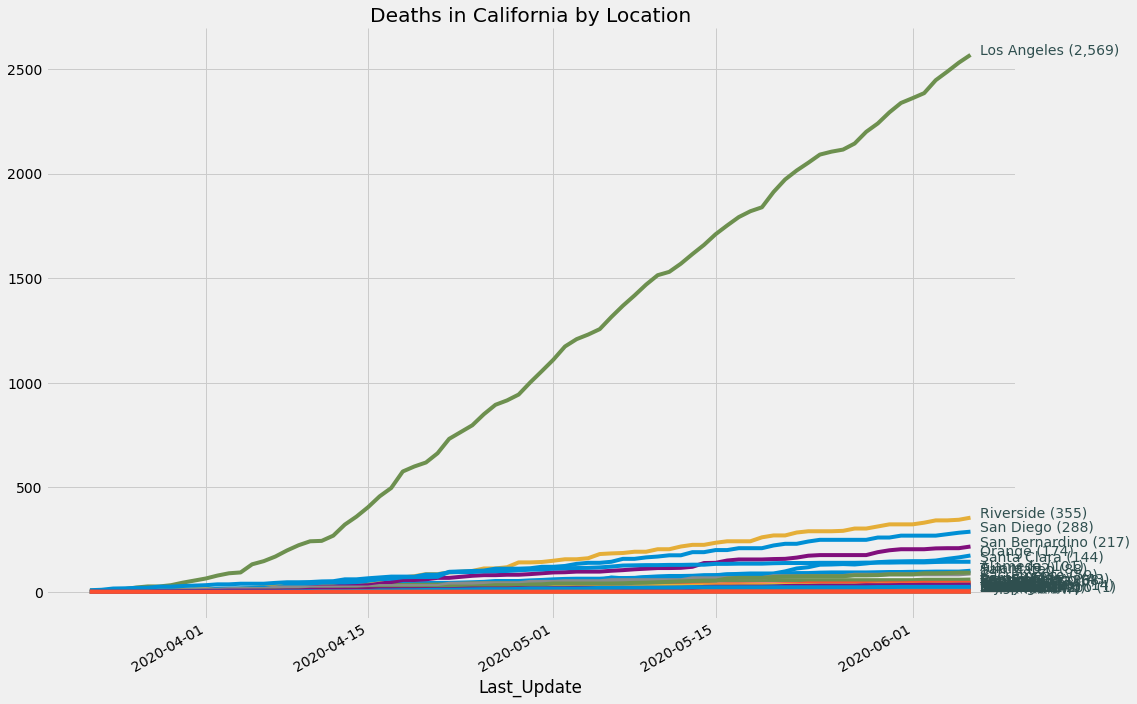

In [16]:
# graph example        
graphdf = (df.loc[:,idx[:,'Deaths',:,'California']]
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )
ax = graphdf.plot(legend=False)
label_lines(graphdf, ax, tuple_selector=4, print_value=True)
plt.title('Deaths in California by Location')
plt.tight_layout()
sns.despine()
plt.show()

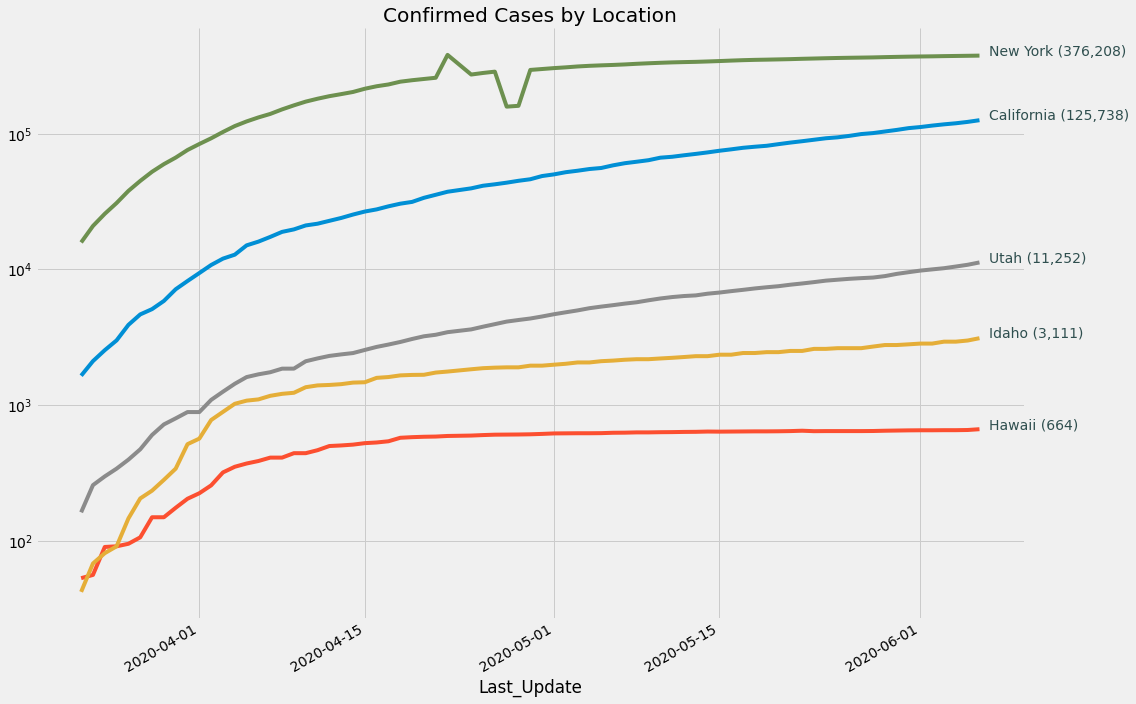

In [17]:
graphdf = (df.loc[:,idx[Any,'Confirmed',Any,['California', 'Utah', 'New York', 'Hawaii', 'Idaho'],Any]]
           .groupby('Province_State', axis='columns')
           .sum()
          )
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, tuple_selector=None, print_value=True)
plt.title('Confirmed Cases by Location')
plt.tight_layout()
sns.despine()
plt.show()


## Creating a table with just a selection of locations (pulled from different levels - countries, states, counties)

In [18]:
locations = {
    'Province_State': idx[:,:,:,['California', 'Utah', 'New York', 'Hawaii', 'Idaho', 'Texas'],:],
    'Country_Region': idx[:,:,['Italy', 'US', 'Spain', 'Japan', 'Singapore'],:,:],
    'Admin2':         idx[:,:,:,:,['Santa Clara', 'Los Angeles']]
}
last_table = None

for level, indexer in locations.items():
    test = (df.loc[:,indexer]
           .groupby(['Metric',level], axis='columns')
           .sum()
       )
    test.rename_axis(('Metric', 'Location'), axis="columns", inplace=True)
    #print(test.info())
    if last_table is None:
        last_table = test
        continue
    last_table = pd.concat([last_table, test], axis=1)
df_select = last_table
df_select

Metric          Active                                             \
Location    California Hawaii   Idaho  New York    Texas     Utah   
Last_Update                                                         
2020-03-22         0.0    0.0     0.0       0.0      0.0      0.0   
2020-03-23         0.0    0.0     0.0       0.0      0.0      0.0   
2020-03-24         0.0    0.0     0.0       0.0      0.0      0.0   
2020-03-25         0.0    0.0     0.0       0.0      0.0      0.0   
2020-03-26         0.0    0.0     0.0       0.0      0.0      0.0   
...                ...    ...     ...       ...      ...      ...   
2020-06-02    110516.0  635.0  2757.0  341794.0  63910.0   9886.0   
2020-06-03    112910.0  636.0  2850.0  343072.0  65594.0  10089.0   
2020-06-04    114974.0  636.0  2850.0  344066.0  67133.0  10380.0   
2020-06-05    117724.0  638.0  2907.0  344959.0  68779.0  10696.0   
2020-06-06    121209.0  647.0  3028.0  345972.0  70736.0  11132.0   

Metric      Case-Fatality_Ratio                                   ...  \
Location             California    Hawaii      Idaho    New York  ...   
Last_Update                                                       ...   
2020-03-22             0.000000  0.000000   0.000000    0.000000  ...   
2020-03-23             0.000000  0.000000   0.000000    0.000000  ...   
2020-03-24             0.000000  0.000000   0.000000    0.000000  ...   
2020-03-25             0.000000  0.000000   0.000000    0.000000  ...   
2020-03-26             0.000000  0.000000   0.000000    0.000000  ...   
...                         ...       ...        ...         ...  ...   
2020-06-02           158.012383  7.612827  52.244111  271.354640  ...   
2020-06-03           154.071391  7.606635  54.553866  269.612604  ...   
2020-06-04           150.248786  7.642490  54.553866  267.238534  ...   
2020-06-05           148.429597  7.636356  52.953721  273.105733  ...   
2020-06-06           144.139181  7.552204  51.667146  286.241958  ...   

Metric           Active             Case-Fatality_Ratio              \
Location    Los Angeles Santa Clara         Los Angeles Santa Clara   
Last_Update                                                           
2020-03-22          0.0         0.0            0.000000    0.000000   
2020-03-23          0.0         0.0            0.000000    0.000000   
2020-03-24          0.0         0.0            0.000000    0.000000   
2020-03-25          0.0         0.0            0.000000    0.000000   
2020-03-26          0.0         0.0            0.000000    0.000000   
...                 ...         ...                 ...         ...   
2020-06-02      53625.0      2635.0            4.259878    5.079251   
2020-06-03      54771.0      2676.0            4.278299    5.072721   
2020-06-04      55772.0      2688.0            4.272155    5.084746   
2020-06-05      57160.0      2706.0            4.241774    5.052632   
2020-06-06      58499.0      2748.0            4.206786    4.979253   

Metric        Confirmed                  Deaths             Incidence_Rate  \
Location    Los Angeles Santa Clara Los Angeles Santa Clara    Los Angeles   
Last_Update                                                                  
2020-03-22        407.0       263.0         5.0         8.0       0.000000   
2020-03-23        536.0       302.0         7.0        10.0       0.000000   
2020-03-24        662.0       375.0        11.0        16.0       0.000000   
2020-03-25        812.0       459.0        13.0        17.0       0.000000   
2020-03-26       1229.0       542.0        21.0        19.0       0.000000   
...                 ...         ...         ...         ...            ...   
2020-06-02      56011.0      2776.0      2386.0       141.0     557.928111   
2020-06-03      57219.0      2819.0      2448.0       143.0     569.961053   
2020-06-04      58261.0      2832.0      2489.0       144.0     580.340463   
2020-06-05      59692.0      2850.0      2532.0       144.0     594.594718   
2

In [19]:
graphdf = df_select['Deaths'].reset_index().melt(id_vars=['Last_Update'])
graphdf

,Last_Update,Location,value
0,2020-03-22,California,30.0
1,2020-03-23,California,39.0
2,2020-03-24,California,50.0
3,2020-03-25,California,65.0
4,2020-03-26,California,81.0
...,...,...,...
983,2020-06-02,Santa Clara,141.0
984,2020-06-03,Santa Clara,143.0
985,2020-06-04,Santa Clara,144.0
986,2020-06-05,Santa Clara,144.0


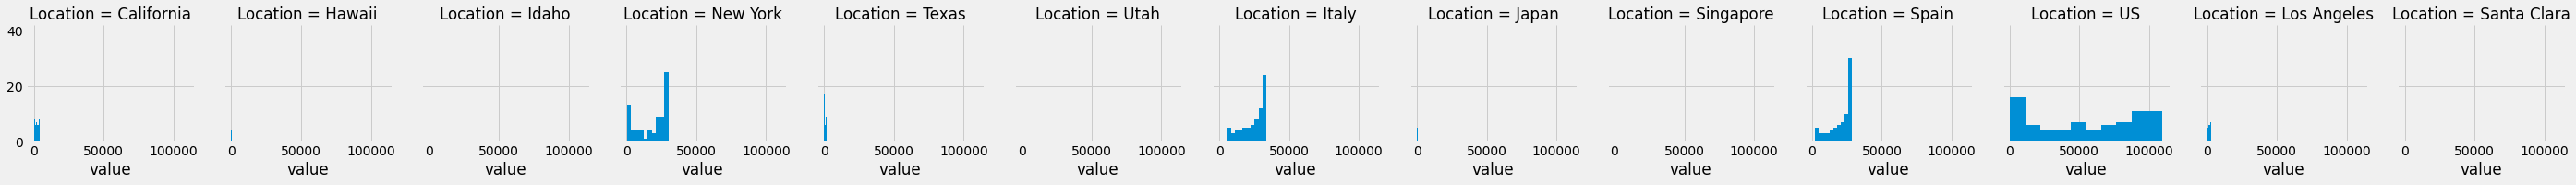

In [20]:
g = sns.FacetGrid(graphdf, col='Location')
g.map(plt.hist, 'value');

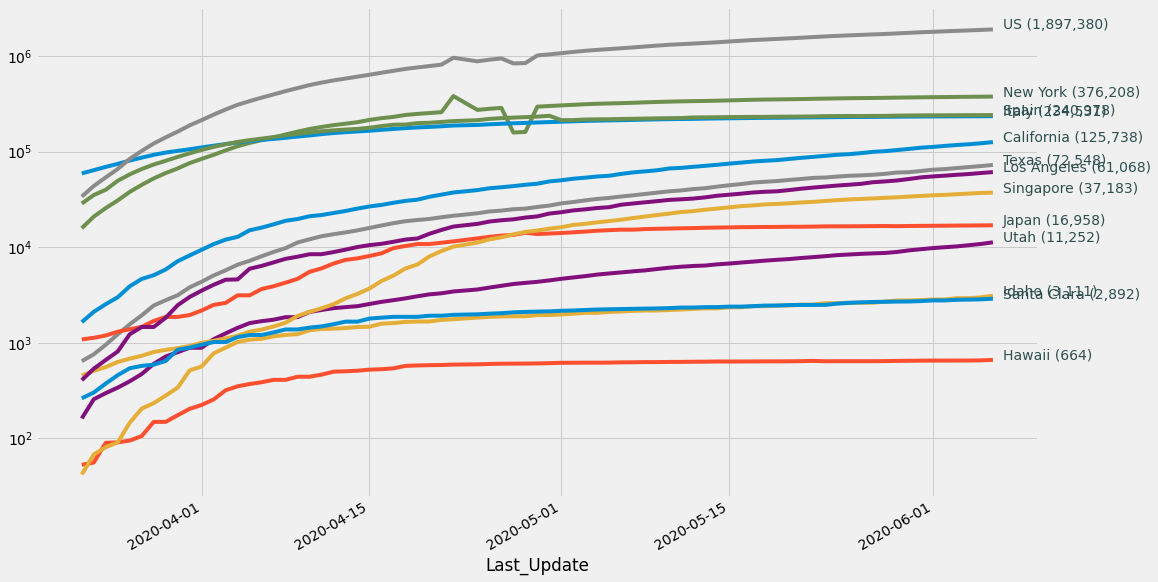

In [21]:
graphdf = df_select['Confirmed']
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, print_value=True)